In [340]:
import math
import numpy as np
import uuid
import matplotlib.pyplot as plt
%matplotlib inline

In [347]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.uuid = uuid.uuid4()
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"{self.label}: Value(Data={self.data})"
    
    def __add__(self, other):
        print("__add__ children", (self, other))
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            print("add backward", self.label, other.label)
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            self._backward()
            other._backward()
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            print("mul backward", self.label, other.label)
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            self._backward()
            other._backward()
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = np.tanh(x)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            print("tanh backward", self.label)
            self.grad = out.grad * (1.0 - t**2)
            self._backward()
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()
            

In [377]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot



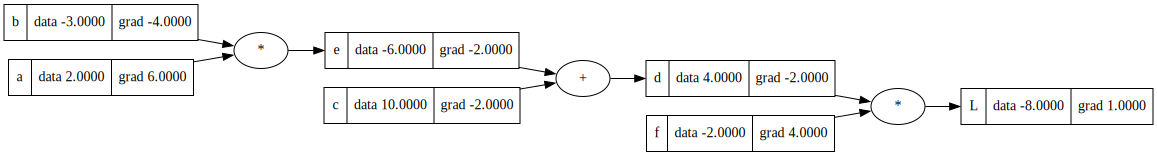

In [241]:
d.grad = f.data
f.grad = d.data
# dL/dc = dL/dd * dd/dc
L.grad = 1
c.grad = d.grad
e.grad = d.grad
b.grad = a.data * e.grad
a.grad = b.data * e.grad

draw_dot(L)

In [184]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
e=a*b
d=c+e
L=d*f
print(L)

Value(Data=-6.586368000000001)


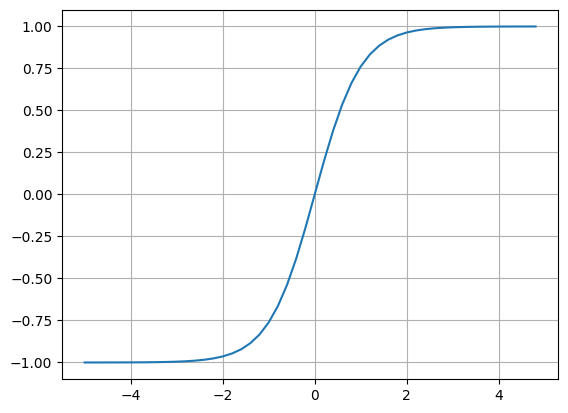

In [188]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()



In [319]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w1')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'


In [286]:
o.grad = 1.0
n.grad = 1.0 - o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x1w1.grad
x1.grad = w1.data * x2w2.grad
x2.grad = w2.data * x2w2.grad


In [288]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(Data=6.881373587019543),
 Value(Data=1.0),
 Value(Data=0.0),
 Value(Data=0.0),
 Value(Data=2.0),
 Value(Data=-3.0),
 Value(Data=-6.0),
 Value(Data=-6.0),
 Value(Data=0.8813735870195432),
 Value(Data=0.7071067811865476)]

tanh backward n
add backward x1*w1 + x2*w2 b
add backward x1*w1 x2*w2
mul backward x2 w1
mul backward x1 w1


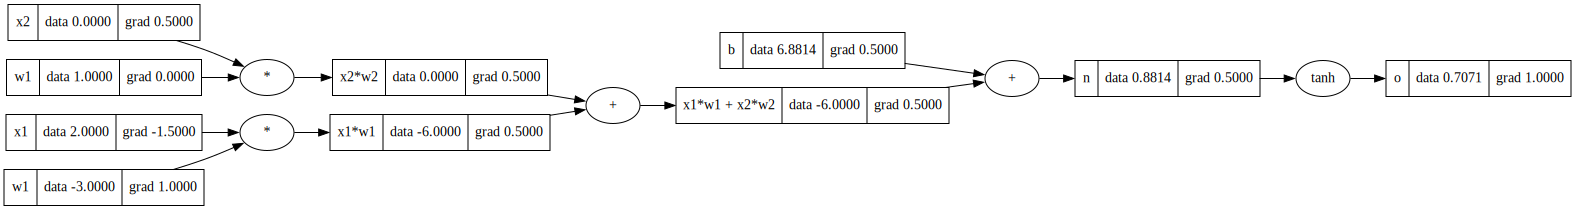

In [378]:
o.backward()
draw_dot(o)

__add__ children (a: Value(Data=3.0), a: Value(Data=3.0))
add backward a a


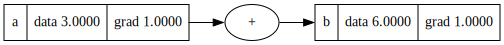

In [379]:
a = Value(3.0, label='a')
aa = Value(3.0, label='aa')
b = a+a; b.label='b'
b.grad = 1.0
b._backward()
draw_dot(b)
# b._prev